# Extract data along a turtle track

This tutorial will teach you how to plot a loggerhead turtle track on a map.
That turtle was raised in captivity in Japan, then tagged and released on 05/04/2005 in the Central Pacific. It transmitted for over 3 years and went all the way to the Southern tip of Baja California!

The track data can be downloaded here:
https://oceanwatch.pifsc.noaa.gov/files/25317_05.dat

Then we'll extract SST and chlorophyll concentration at each location along the track, and plot the data.

## Load packages

In [222]:
import pandas as pd 
import numpy as np 
import urllib.request 
import xarray as xr 
import netCDF4 as nc 
import time
from matplotlib import pyplot as plt 
from matplotlib.colors import LinearSegmentedColormap,BoundaryNorm,Normalize
from mpl_toolkits.basemap import Basemap
from datetime import date,datetime

np.warnings.filterwarnings('ignore')

- Let's load the track data:

In [ ]:
df=pd.read_csv('25317_05.dat')

In [289]:
df.head()

,mean_lon,mean_lat,year,month,day
0,176.619433,32.678728,2005,5,4
1,176.783786,32.755451,2005,5,5
2,177.086095,32.870337,2005,5,6
3,177.523857,32.859396,2005,5,7
4,178.058145,32.674011,2005,5,8


## Let's plot the track on a map:

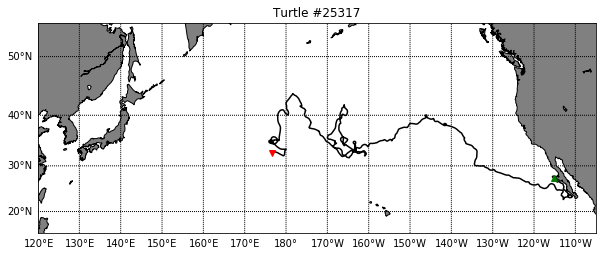

In [292]:
# Setup the bounding box for the zoom and bounds of the map
bbox=[120 ,255, 15, 55]
    
plt.figure(figsize=(10,10))
# Define the projection, scale, the corners of the map, and the resolution.
m = Basemap(projection='merc',llcrnrlat=bbox[2],urcrnrlat=bbox[3],\
            llcrnrlon=bbox[0],urcrnrlon=bbox[1],lat_ts=10,resolution='l')

# Draw coastlines and fill continents and water with color
m.drawcoastlines()
m.fillcontinents(color='gray')

m.drawmeridians(np.arange(bbox[0], bbox[1], 10),labels=[0,0,0,1])
m.drawparallels(np.arange(bbox[2]+5, bbox[3], 10),labels=[1,0,0,0])

# build and plot coordinates onto map
x,y = m(list(df.mean_lon),list(df.mean_lat))
m.plot(x,y,color='k')
m.plot(x[0],y[0],marker='v',color='r')
m.plot(x[-1],y[-1],marker='^',color='g')
plt.title("Turtle #25317")
plt.show()

## Now let's extract data along the track

We are going to grab data from ERDDAP, so we need to set up the ERDDAP URLs using their datasets IDs and the name of the variables we are interested in.
Note that we are requesting the data as .csv

### Chlorophyll-a concentration

In [ ]:
MOD_d = "https://oceanwatch.pifsc.noaa.gov/erddap/griddap/aqua_chla_1d_2018_0.csv?chlor_a"

Ideally, we would work with daily data since we have one location per day. But chlorophyll data is severely affected by clouds (i.e. lots of missing data), so you might need to use weekly or even monthly data to get sufficient non-missing data. 

Run all 3 of them, and plot a time-series of each to compare (as a separate exercise).

In [ ]:
MOD_w = "https://oceanwatch.pifsc.noaa.gov/erddap/griddap/aqua_chla_8d_2018_0.csv?chlor_a" 
MOD_m = "https://oceanwatch.pifsc.noaa.gov/erddap/griddap/aqua_chla_monthly_2018_0.csv?chlor_a"

In [ ]:
lon=df.mean_lon
lat=df.mean_lat

We need to format the dates in a way that ERDDAP understands, i.e. 2010-12-15

In [ ]:
dates=[]
for i in range(len(df.month)):
    dates.append(date(df.year[i],df.month[i],df.day[i]).strftime('%Y-%m-%d'))

In [287]:
dates[0]

'2005-05-04'

For each date and location, we'll extract a value of CHL or SST. To do this, we need to pass those parameters (which dataset, which date, which lon, and which lat) to ERDDAP by building the URL.

This can take a long time to run (about 15 mins), we are making 1200+ requests to a remote server. For the purpose of the exercise, you can just run the below code on the first 100 points of the turtle track.

In [ ]:
start_time=time.time()
col_names =  ["date","matched_lat","matched_lon","matched_chla"]
tot=pd.DataFrame(columns = col_names)

for i in range(len(dates)):
#for i in range(5):
    print(i,len(dates))
    #this is where the URL is built:
    url=MOD_m+"[("+str(dates[i])+"):1:("+str(dates[i])+")][("+str(lat[i])+"):1:("+str(lat[i])+")][("+str(lon[i])+"):1:("+str(lon[i])+")]"
    new=pd.read_csv(url,skiprows=1)
    new.columns=col_names
    tot=tot.append(new,ignore_index=True)

end_time=time.time()


In [293]:
print("total time = %g mins" % ((end_time-start_time)/60.))

total time = 14.4734 mins


In [185]:
tot.head()

,date,matched_lat,matched_lon,matched_chla
0,2005-05-16T12:00:00Z,32.687500,176.60417,0.147827
1,2005-05-16T12:00:00Z,32.770832,176.77083,0.168947
2,2005-05-16T12:00:00Z,32.854168,177.10417,0.258081
3,2005-05-16T12:00:00Z,32.854168,177.52083,0.171364
4,2005-05-16T12:00:00Z,32.687500,178.06252,0.296886


We now have a value of monthly chlorophyll-a concentration for each location/date combination along the turtle track.

## On your own!

- Exercise 1:
Repeat the steps above with a different dataset.
For example, extract sea surface temperature data using the following dataset:
https://oceanwatch.pifsc.noaa.gov/erddap/griddap/CRW_sst_v1_0.html


- Exercise 2:
Go to an ERDDAP of your choice, find a dataset of interest, generate the URL, copy it and edit the script above to run a match up on that dataset.
To find other ERDDAP servers, you can use this search engine:
http://erddap.com/

Note! some ERDDAPs are slower than others, so this could take a lot longer. 
If it takes too long, adjust the "for" loop to request data for only the first 100 days of our track.

## Plot #2

Let's plot the track, color coded using values of monthly chlorophyll concentration.


- Let's create a color scale

In [187]:
jet=["blue", "#007FFF", "cyan","#7FFF7F", "yellow", "#FF7F00", "red", "#7F0000"] 

- Let's look at the range of log of monthly chlorophyll values:

In [190]:
np.min(np.log(tot.matched_chla)),np.max(np.log(tot.matched_chla))

(-2.8923874400191183, 2.136305926186285)

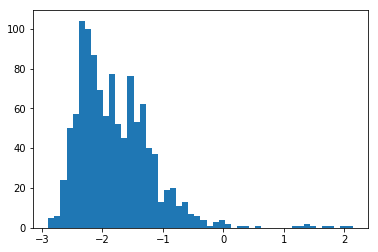

In [195]:
n, bins, patches=plt.hist(np.log(tot.matched_chla[~np.isnan(tot.matched_chla)]),50)
plt.show()

The range of log(chl-a) is -2.9 to 2.2 but most of the values are between -2.9 and 0. 

We use the log because the range of chlorophll values can be pretty big, with lots of very low values, and a few very high values.

In [263]:
levs = np.append(np.arange(-2.9,0,0.1),2.2)
cm = LinearSegmentedColormap.from_list('my_jet', jet, N=len(levs))

BoundaryNorm will force the colorbar to use the breaks in levs.

In [290]:
norm = BoundaryNorm(levs, len(levs))

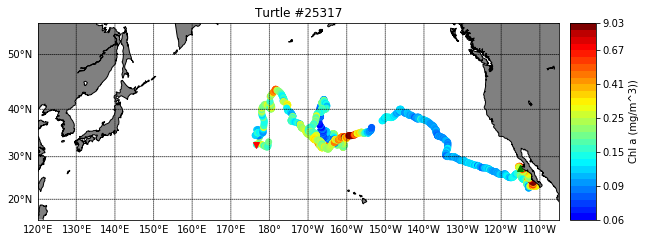

In [291]:
# Setup the bounding box for the zoom and bounds of the map
bbox=[120 ,255, 15, 55]
    
plt.figure(figsize=(10,10))
# Define the projection, scale, the corners of the map, and the resolution.
m = Basemap(projection='merc',llcrnrlat=bbox[2],urcrnrlat=bbox[3],\
            llcrnrlon=bbox[0],urcrnrlon=bbox[1],lat_ts=10,resolution='l')

# Draw coastlines and fill continents and water with color
m.drawcoastlines()
m.fillcontinents(color='gray')

m.drawmeridians(np.arange(bbox[0], bbox[1], 10),labels=[0,0,0,1])
m.drawparallels(np.arange(bbox[2]+5, bbox[3], 10),labels=[1,0,0,0])

# build and plot coordinates onto map
x,y = m(list(df.mean_lon),list(df.mean_lat))
m.scatter(x,y,c=np.log(tot.matched_chla),cmap=cm,norm=norm)

m.plot(x[0],y[0],marker='v',color='r')
m.plot(x[-1],y[-1],marker='^',color='g')

#let's customize the color bar so the label reflect values of chl-a, not log(chl-a)
#we build levs2 to have the labels more spaced out than the values in levs
levs2=np.append(np.arange(-2.9,0,0.5),2.2)
cbar=m.colorbar(fraction=0.022,ticks=levs2, label='Chl a (mg/m^3))')
#and set the labels to be exp(levs2)
cbar.ax.set_yticklabels(np.around(np.exp(levs2),2))

plt.title("Turtle #25317")
plt.show()